##Load SDE Star Data from sde_data.zip##

In [1]:
# Load dataframe from zip file
import pandas as pd
# !wget https://github.com/jrslagle/Build_1/blob/main/sde_stars.zip
star_data = pd.read_csv('sde_stars.zip')
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181


In [ ]:
star_data.profile_report()
# https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/installation.html

AttributeError: ignored

In [ ]:
# Save dataframe to zip file
compression_opts = dict(method='zip', archive_name='out.csv')
star_data.to_csv('sde_stars.zip', index=False, compression=compression_opts)

In [ ]:
# Load Star Data from a Local File
from google.colab import files
import pickle
uploaded = files.upload()
star_filename = [file for file in uploaded.keys()][0]

# star_filename = 'stars.dat'
# stars.dat is hosted at https://drive.google.com/file/d/10F5tGDqOoXYHMksiM3O3z71nZEaAv3Qr
star_data = pickle.load( open( star_filename, "rb" ) )
print('Shape =',star_data.shape)
star_data.head()

In [ ]:
# Load star_data.dat from my Google Drive

# Authenticate and Mount Google Drive
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload

auth.authenticate_user()
drive_service = build('drive', 'v3')

# Notes on importing data   https://colab.research.google.com/notebooks/io.ipynb#scrollTo=vz-jH8T_Uk2c

# Load star_data hosted on Google Drive
import pickle

# stars.dat is hosted at https://drive.google.com/file/d/1Tg0VbIORgvxTpFRcuHOy9pfO2Lo9qjQN/view?usp=sharing
file_ids = {'star_data':'1Tg0VbIORgvxTpFRcuHOy9pfO2Lo9qjQN',
            'trig_logo':'1YXRPwrgujrilfvy81K6XdNYgMcX1vwR_'}

def download(file_id):
  request = drive_service.files().get_media(fileId = file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
  downloaded.seek(0)
  return downloaded

esi_stars = pickle.load( download(file_ids['star_data']) )
print('Shape =',esi_stars.shape)
esi_stars.head()

##Extract Star Data from sde.zip##

In [ ]:
# Parse and Extract data from sde.zip

from zipfile import ZipFile
import re
import numpy as np
import yaml
import pandas as pd

# Download the Static Data Export (SDE) file (103 MB)
!wget https://eve-static-data-export.s3-eu-west-1.amazonaws.com/tranquility/sde.zip
# from https://developers.eveonline.com/resource/resources
# https://www.geeksforgeeks.org/working-zip-files-python/

# Get solar system file paths
def getPaths(domains):
  system_file_paths = []
  with ZipFile('sde.zip', 'r') as zip:
    sde_files = zip.namelist()
    for domain in domains:
      pattern = '(^sde/fsd/universe/' +domain+ '.+/solarsystem.staticdata$)'
      matches = (re.search(pattern, line) for line in sde_files)
      system_file_paths.extend([match.group(1) for match in matches if match])
    zip.close()
  return system_file_paths

# All domains are ['abyssal', 'eve', 'penalty', 'wormhole']
system_file_paths = getPaths(['eve', 'wormhole']) # these domains have stars
print('Got file paths for',format(len(system_file_paths),',d'),'solar system files')

# sde.zip contains 9,597 files.
# There are 8,285 systems, each with a solarsystem.staticdata file.
# Systems are in folders 'sde/fsd/universe/' + ['abyssal', 'eve', 'penalty', 'wormhole']
# Of those, 8,035 systems have a star
# abyssal = 200 systems (no stars)
# eve = 5,431 systems (has stars)
# penalty = 50 systems (no stars)
# wormhole = 2,604 systems (has stars)

# Parse and Extract data from sde.zip
def extract_stars_from_sde():
  data = {'domain':[],
          'region':[],
          'constellation':[],
          'system_name':[],
          'security':[],
          'solar_system_id':[],
          'star_id':[],
          'star_type_id':[],
          'star_age':[],
          'star_life':[],
          'star_locked':[],
          'star_luminosity':[],
          'star_radius':[],
          'star_spectralClass':[],
          'star_temperature':[]}

  print('Progress  Region')
  n = len(system_file_paths)
  with ZipFile('sde.zip', 'r') as zip:
    last_region = 'None'
    for i, filepath in enumerate(system_file_paths):
      # filepath = 'sde/fsd/universe/eve/SinqLaison/Coriault/Botane/solarsystem.staticdata'

      # ['sde', 'fsd', 'universe', 'eve', 'A821-A', '6I-9Y2', 'E-RPGP', 'solarsystem.staticdata']
      (_,_,_,domain,region,constellation,system_name,_) = filepath.split('/')

      # Print Progress
      if last_region != region:
        last_region = region
        progress = format((i/n)*100,'.1f')+'%'
        print(progress,region)

      try:
        yaml_data = yaml.safe_load(zip.read(filepath))
      except yaml.YAMLError as exc:
        print(exc)
      
      # print(yaml_data)
      # d['domain'].append(domain) if 'domain' else d['domain'].append(None)

      # File path components
      data['domain'].append(domain if domain else None)
      data['region'].append(region if region else None)
      data['constellation'].append(constellation if constellation else None)
      data['system_name'].append(system_name if system_name else None)

      # System componenets
      data['security'].append(yaml_data['security'] if 'security' in yaml_data else None)
      data['solar_system_id'].append(yaml_data['solarSystemID'] if 'solarSystemID' in yaml_data else np.nan)

      # Star componenets
      data['star_id'].append(yaml_data['star']['id'] if 'star' in yaml_data else np.nan)
      data['star_type_id'].append(yaml_data['star']['typeID'] if 'star' in yaml_data else np.nan)
      data['star_age'].append(yaml_data['star']['statistics']['age'] if 'star' in yaml_data else np.nan)
      data['star_life'].append(yaml_data['star']['statistics']['life'] if 'star' in yaml_data else np.nan)
      data['star_locked'].append(yaml_data['star']['statistics']['locked'] if 'star' in yaml_data else None)
      data['star_luminosity'].append(yaml_data['star']['statistics']['luminosity'] if 'star' in yaml_data else np.nan)
      data['star_radius'].append(yaml_data['star']['statistics']['radius'] if 'star' in yaml_data else np.nan)
      data['star_spectralClass'].append(yaml_data['star']['statistics']['spectralClass'] if 'star' in yaml_data else np.nan)
      data['star_temperature'].append(yaml_data['star']['statistics']['temperature'] if 'star' in yaml_data else np.nan)
      

    zip.close()
    # for key in data.keys():
    #   print(key,'=',len(key))
  return pd.DataFrame(data)
  # return data
star_data = extract_stars_from_sde()

# print('Shape =', sde_stars.shape)
# print('Dtypes =', sde_stars.dtypes)
star_data

# esi_stars = ['age', 'luminosity', 'name', 'radius', 'solar_system_id',
#       'spectral_class', 'temperature', 'type_id', 'star_id']

# solar_system_keys = ['border', 'center', 'corridor', 'fringe', 'hub',
# 'international', 'luminosity', 'max', 'min', 'planets', 'radius',
# 'regional', 'security', 'securityClass', 'solarSystemID',
# 'solarSystemNameID', 'star', 'stargates', 'sunTypeID']

# security: 0.5829538102925483
# solarSystemID: 30002675
# star:
#     id: 40170258
#     radius: 598100000
#     statistics:
#         age: 3.507e+17
#         life: 1.414e+18
#         locked: false
#         luminosity: 0.1417
#         radius: 598100000.0
#         spectralClass: K8 V
#         temperature: 3640.0
#     typeID: 7

0.0% A821-A
0.6% Aridia
1.6% BlackRise
2.2% Branch
3.3% Cache
3.9% Catch
5.2% CloudRing
5.7% CobaltEdge
6.6% Curse
7.2% Deklein
8.1% Delve
9.3% Derelik
10.7% Detorid
11.9% Devoid
12.6% Domain
15.0% Esoteria
16.0% Essence
16.9% EtheriumReach
18.1% Everyshore
18.8% Fade
19.1% Feythabolis
20.2% Fountain
21.7% Geminate
22.7% Genesis
24.0% GreatWildlands
25.2% Heimatar
26.3% Immensea
27.3% Impass
28.0% Insmother
29.3% J7HZ-F
30.3% Kador
31.3% Khanid
32.4% Kor-Azor
33.1% Lonetrek
34.4% Malpais
35.6% Metropolis
37.6% MoldenHeath
38.1% Oasa
39.1% Omist
39.7% OuterPassage
40.8% OuterRing
41.5% ParagonSoul
42.0% PeriodBasis
42.5% PerrigenFalls
43.8% Placid
44.7% Providence
45.7% PureBlind
46.8% Querious
48.0% ScaldingPass
49.0% SinqLaison
50.3% Solitude
50.9% Stain
52.5% Syndicate
53.8% Tash-Murkon
55.1% Tenal
55.9% Tenerifis
57.0% TheBleakLands
57.4% TheCitadel
58.5% TheForge
59.6% TheKalevalaExpanse
60.5% TheSpire
61.4% Tribute
62.0% UUA-F4
63.4% ValeoftheSilent
64.8% Venal
66.0% VergeVendor
6

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181


In [ ]:
eve_stars = star_data[sde_stars['domain'] == 'eve']
eve_stars

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.02956,125100000.0,G5 VI,5378.0
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.10810,155800000.0,K1 V,4713.0
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.29050,161000000.0,G0 V,5936.0
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.30090,106600000.0,F0 VI,7360.0
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.01935,226400000.0,K9 V,3596.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5426,eve,WickedCreek,RF9-ZU,H-HHTH,-0.421542,30000547,40034158,45039,1.588000e+18,2.303000e+18,False,0.03290,536700000.0,M4 V,2668.0
5427,eve,WickedCreek,RF9-ZU,JQU-KY,-0.267341,30000548,40034226,6,1.664000e+17,4.033000e+17,False,0.41290,481600000.0,G6 V,5300.0
5428,eve,WickedCreek,RF9-ZU,MWA-5Q,-0.307662,30000546,40034109,9,4.656000e+16,2.004000e+17,False,0.37420,316200000.0,F7 VI,6382.0
5429,eve,WickedCreek,RF9-ZU,UY5A-D,-0.404798,30000549,40034268,6,3.951000e+17,4.787000e+17,False,0.85090,727800000.0,G8 V,5166.0


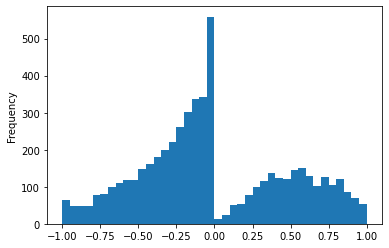

In [ ]:
eve_stars.security.plot.hist(bins=40);

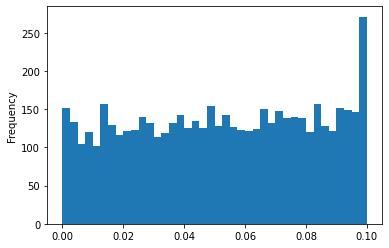

In [ ]:
(eve_stars.security % 0.1).plot.hist(bins=40);

##Scraping Star Data from ESI##

In [6]:
# Connect to the ESI API.
!pip install bravado
from bravado.client import SwaggerClient
import bravado.exception
client = SwaggerClient.from_url('https://esi.evetech.net/_latest/swagger.json?datasource=tranquility')
# https://pypi.org/project/bravado/

     |████████████████████████████████| 71kB 1.8MB/s 
     |████████████████████████████████| 133kB 6.9MB/s 
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp36-none-any.whl size=18122 sha256=d1b097deedabbadf0e4127678babacc6f2b46eaf390a935f265f80c4779e5184
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [ ]:
# If you don't have stars.dat, set up for scraping it.
system_ids = client.Universe.get_universe_systems().result()
print('Got the System IDs for',len(system_ids),'systems in New Eden.')
# The first 8,035 have stars, the last 250 don't.

stars = []
star_ids = []
systems = []

Got the System IDs for 8285 systems in New Eden.


In [ ]:
# Gather stars from system_id's (takes ~30 minutes)
# You can run this multiple times because it errors out part way through

starting_index = len(star_ids)
# ending_index = min(starting_index+100, len(system_ids))
ending_index = len(system_ids)-250
print('['+str(starting_index)+':'+str(ending_index)+']')
for system_id in system_ids[starting_index:ending_index]:
  system = client.Universe.get_universe_systems_system_id(system_id=system_id).result()
  star = None
  if system.star_id is not None:
    # star = client.Universe.get_universe_stars_star_id(star_id=system.star_id).result()
    # stars.append(star)
    star_ids.append(system.star_id)

print('Finished cataloging all',ending_index,'stars.')
# print('Now taking the Nones off the end')
# while stars[-1] is None:
#   stars.pop()

[3495:8035]


HTTPBadGateway: ignored

In [ ]:
# Check to make sure all stars are in the right positions
misses = 0
for i, star in enumerate(stars):
  if star:
    star_system_id = star.solar_system_id
    system_id = system_ids[i]
    if star_system_id != system_id:
      print(str(i)+': system_id='+str(system_id)+', but its star says '+str(star_system_id))
      misses += 1
  else:
    print(str(i)+': system_id='+str(system_ids[i])+', but its star says '+str(star))
    misses += 1
print(misses,'systems were off.')

In [ ]:
# Construct the star_data dataframe from the array of star objects scraped
star_data = pd.DataFrame(columns=['age','luminosity','name','radius','solar_system_id','spectral_class','temperature','type_id'])
for i, star in enumerate(stars):
  star_data.at[i, 'star_id'] = star_ids[i]
  star_data.at[i, 'age'] = star.age
  star_data.at[i, 'luminosity'] = star.luminosity
  star_data.at[i, 'name'] = star.name
  star_data.at[i, 'radius'] = star.radius
  star_data.at[i, 'solar_system_id'] = star.solar_system_id
  star_data.at[i, 'spectral_class'] = star.spectral_class
  star_data.at[i, 'temperature'] = star.temperature
  star_data.at[i, 'type_id'] = star.type_id
star_data.head()

In [ ]:
star_data.head(20)

,age,luminosity,name,radius,solar_system_id,spectral_class,temperature,type_id
0,14262808228,0.01575,Tanoo - Star,63350000,30000001,K2 V,4567,45041
1,11721423806,0.01282,Lashesih - Star,133000000,30000002,K4 V,4234,45037
2,5434507143,0.62130,Akpivem - Star,255000000,30000003,G2 V,5705,3799
3,12250614907,0.34610,Jark - Star,477100000,30000004,G8 V,5095,45030
4,6027074244,0.02403,Sasta - Star,588300032,30000005,M7 V,2355,45040
5,10159200904,0.02324,Zaid - Star,214500000,30000006,K7 V,3868,45031
6,40434000417,0.01469,Yuzier - Star,267200000,30000007,M2 V,3091,3800
7,54598575437,0.03981,Nirbhi - Star,467000000,30000008,M2 V,2999,45039
8,19846250470,0.01479,Sooma - Star,280000000,30000009,M2 V,3024,45039
9,20803228893,0.07498,Chidah - Star,341200000,30000010,K5 V,4111,8


In [ ]:
# save star_data to a file
import pickle
star_filename = 'stars.dat'
pickle.dump( star_data, open( star_filename, "wb" ) )
!wget {star_filename}

--2020-09-21 09:11:35--  http://stars.dat/
Resolving stars.dat (stars.dat)... failed: Name or service not known.
wget: unable to resolve host address ‘stars.dat’


In [ ]:
# Scratch Work

# print('I now have',len(stars),'stars.')
# star_two = client.Universe.get_universe_stars_star_id(star_id=system_two.star_id).result()
# star_two = client.Universe.get_universe_stars_star_id(star_id=star_ids[2]).result()
# print(star_two.luminosity)
# print(star_two.temperature)
# for star in star_ids[:100]
# response = client.Universe.post_universe_ids(names=['Dodixie']).result()['systems'][0].id
# print(response)
# print(system_ids[starting_index:ending_index])
# star = None
# if system.star_id is not None:
#   star = client.Universe.get_universe_stars_star_id(star_id=system.star_id).result()
# print(star_two)
# print('star =',star)
# print(stars[-1])
# print(type(stars[0]))

# a_system = client.Universe.get_universe_systems_system_id(system_id=system_ids[43]).result()
# print('system =',a_system)

# print(star_data['type_id'].value_counts())

star_data['type_id'] = star_data['type_id'].apply(int)
# print(type(star_data['age'][300]))

# star_data.describe()
# print(star_data.dtypes)
print("Number of unique values in the Stars data")
for column in star_data.columns:
  print(column,'=',star_data[column].nunique(),star_data[column].dtypes)
star_data.head()

Number of unique values in the Stars data
age = 4052 int64
luminosity = 4186 float64
name = 8035 object
radius = 3555 int64
solar_system_id = 8035 int64
spectral_class = 89 object
temperature = 3159 int64
type_id = 29 int64


,age,luminosity,name,radius,solar_system_id,spectral_class,temperature,type_id
0,14262808228,0.01575,Tanoo - Star,63350000,30000001,K2 V,4567,45041
1,11721423806,0.01282,Lashesih - Star,133000000,30000002,K4 V,4234,45037
2,5434507143,0.62130,Akpivem - Star,255000000,30000003,G2 V,5705,3799
3,12250614907,0.34610,Jark - Star,477100000,30000004,G8 V,5095,45030
4,6027074244,0.02403,Sasta - Star,588300032,30000005,M7 V,2355,45040


In [ ]:
a_system = client.Universe.get_universe_systems_system_id(system_id=system_ids[43]).result()
a_star = client.Universe.get_universe_stars_star_id(star_id=a_system.star_id).result()

# a_belt = client.Universe.get_universe_asteroid_belts_asteroid_belt_id()
belts = [planet.asteroid_belts for planet in a_system.planets if planet.asteroid_belts]
# print(a_system.planets[0].asteroid_belts)
print(a_system.name+':',belts)



Faspera: [[40002842], [40002846], [40002848], [40002852], [40002854]]


## Merge/Compare ESI Star data with the SDE Star Data ##

In [ ]:
merged = pd.merge(star_data, star_system_key, on='solar_system_id', how='inner')
print(merged.shape)
merged

(8035, 10)


,age,luminosity,name,radius,solar_system_id,spectral_class,temperature,type_id,star_id_x,star_id_y
0,14262808228,0.015750,Tanoo - Star,63350000,30000001,K2 V,4567,45041,40000001,40000001
1,11721423806,0.012820,Lashesih - Star,133000000,30000002,K4 V,4234,45037,40000019,40000019
2,5434507143,0.621300,Akpivem - Star,255000000,30000003,G2 V,5705,3799,40000040,40000040
3,12250614907,0.346100,Jark - Star,477100000,30000004,G8 V,5095,45030,40000129,40000129
4,6027074244,0.024030,Sasta - Star,588300032,30000005,M7 V,2355,45040,40000190,40000190
...,...,...,...,...,...,...,...,...,...,...
8030,474089189,31.407612,J000652 - Star,1306936064,31002600,A0IV,8583,34331,40488356,40488356
8031,482438370,32.740738,J000313 - Star,1290598144,31002601,A0IV,9364,34331,40488362,40488362
8032,481478122,29.646883,J000687 - Star,1183918976,31002602,A0IV,8773,34331,40488372,40488372
8033,471948823,33.121517,J000427 - Star,1229130752,31002603,A0IV,9844,34331,40488380,40488380


##Star Data Exploration##

###General Exploration###

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


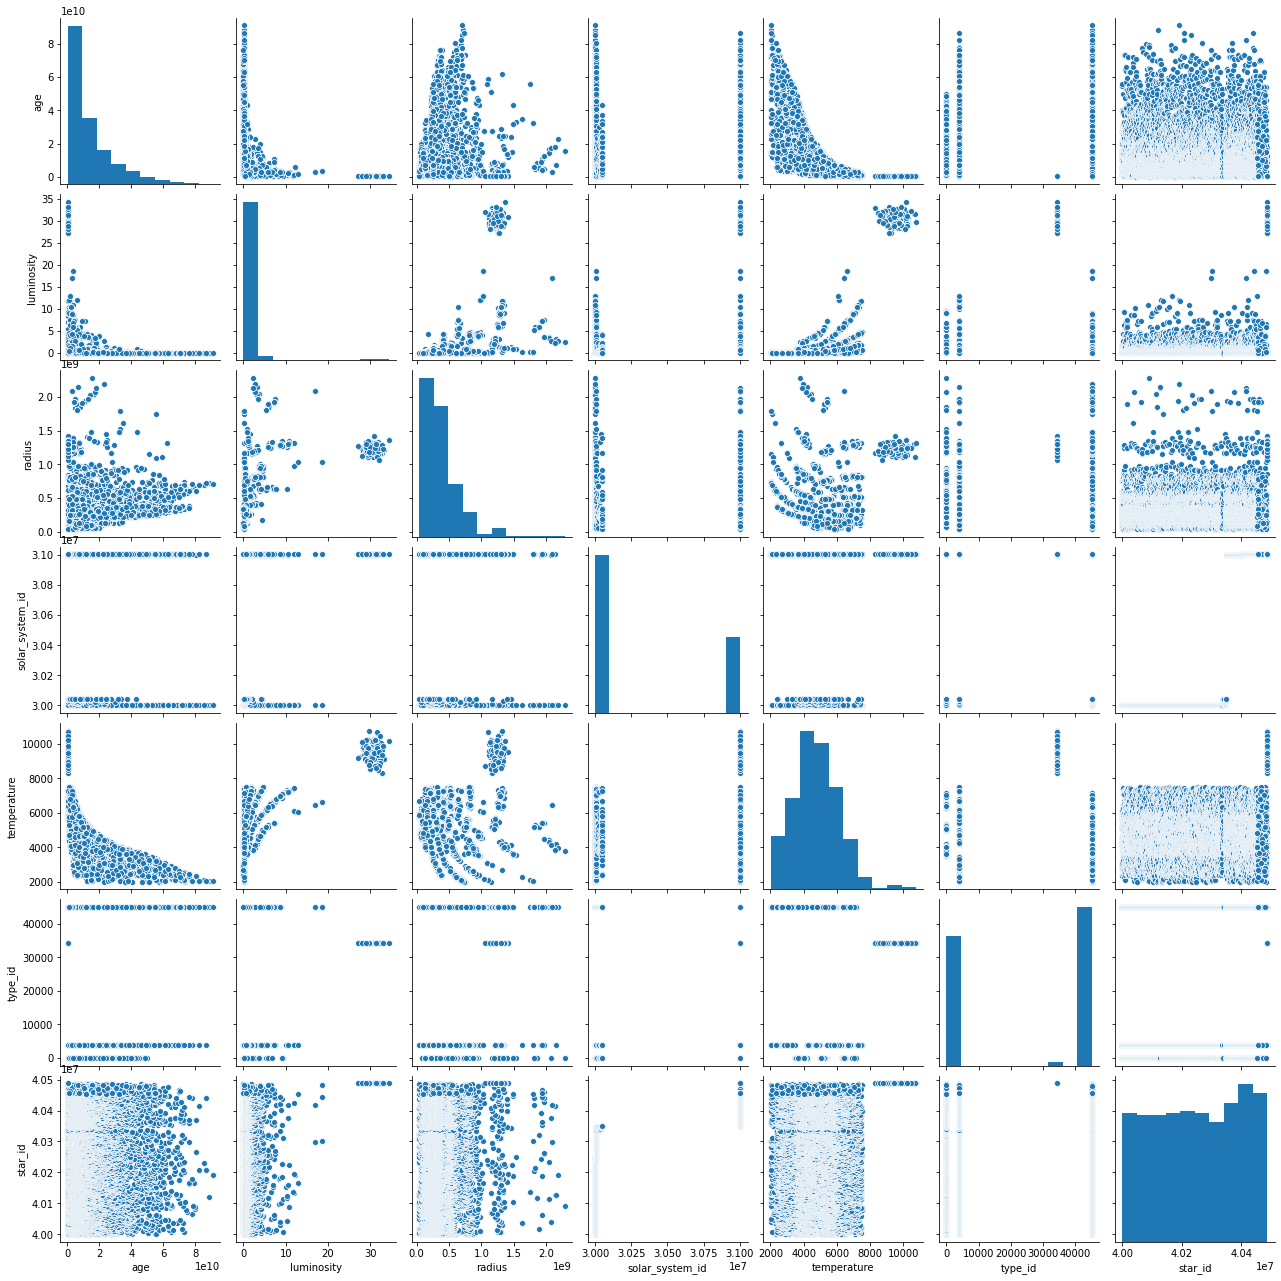

In [ ]:
# A Seaborn plot to explore the data.
import seaborn as sns
g = sns.pairplot(star_data)

In [ ]:
sde_stars['star_type_id'].value_counts().sort_index()

6        285
7        311
8        327
9         75
10        96
3796     225
3797     311
3798     361
3799     294
3800     427
3801     251
3802     494
3803     111
34331    106
45030    298
45031    267
45032    300
45033    382
45034     72
45035     97
45036    322
45037    394
45038    342
45039    457
45040    391
45041    526
45042    132
45046     88
45047    293
Name: star_type_id, dtype: int64

In [ ]:
sde_stars['star_spectralClass'].value_counts().sort_index()

A0         1
A0IV     100
A0IV2      5
F0 IV      2
F0 V      65
        ... 
M5 V     152
M6 V     168
M7 V      40
M8 V      47
M9 V      45
Name: star_spectralClass, Length: 89, dtype: int64

In [ ]:
sde_stars

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181


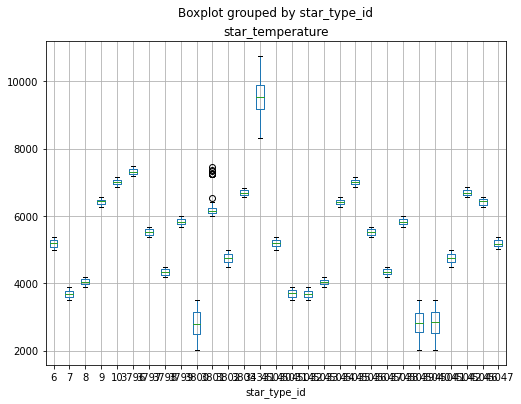

In [ ]:
sde_stars.boxplot(column='star_temperature', by='star_type_id', figsize=(8,6));

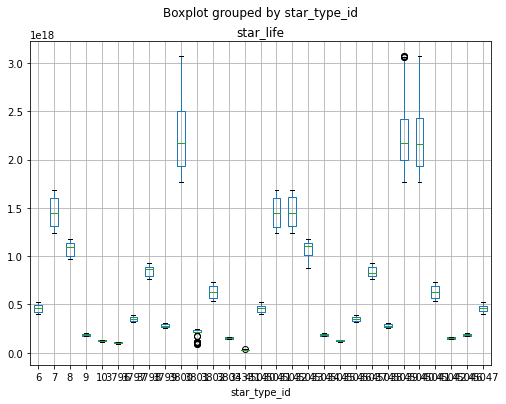

In [ ]:
sde_stars.boxplot(column='star_life', by='star_type_id', figsize=(8,6));

###The Bright Blue Giants###
There are 106 stars in Eve which are much hotter, brighter, and larger than the normal stock. One of them is Thera - the only hand-crafted system. They are all in wormhole systems, but relatively rare at 106/2604 = 4.07% of wormholes. They are hotter: 8,307-10,764 K vs 2,010-7,496 K for normal stars. And they are brighter too: 27.2-34.4 vs 0.01-18.57. They are also larger than normal stars, but the ranges overlap some. They are all star type id 34331. Their spectral classes are ['A0IV', 'A0', 'A0IV2']. It's interesting that the distribution of brightness is roughly two merged bell curves, even when you split the data by spectral class. These stars can be filtered by luminosity > 25, but also by type id 34331.

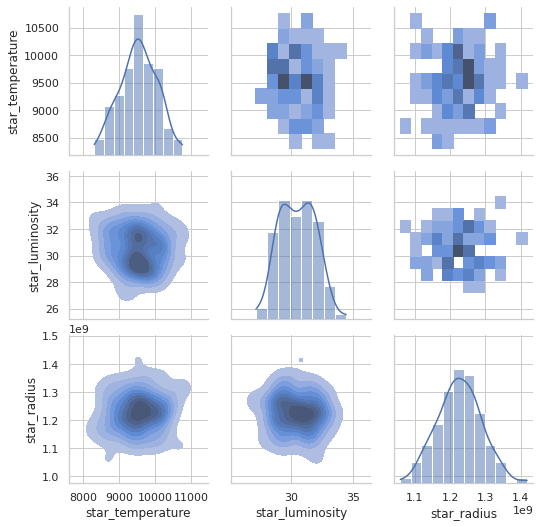

In [ ]:
# !pip install --user --upgrade seaborn
# import seaborn as sns

g = sns.PairGrid(bright_stars[['star_temperature','star_luminosity','star_radius']])
# g.map_upper(sns.histplot)
g.map_upper(sns.scatterplot, s=15)
g.map_diag(sns.histplot, kde=True);
g.map_lower(sns.kdeplot, fill=True)

# https://seaborn.pydata.org/examples/pair_grid_with_kde.html

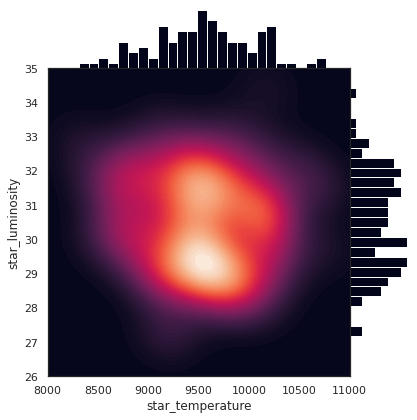

In [ ]:
# A fancy plot of the 
!pip install --user --upgrade seaborn
import seaborn as sns

bright_stars = sde_stars[sde_stars['star_type_id'] == 34331]
sns.set_theme(style="white")
g = sns.JointGrid(data=bright_stars, x="star_temperature", y="star_luminosity", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((8000, 11000), (26, 35)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25);

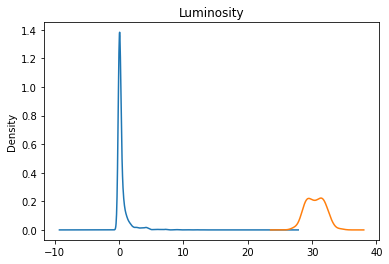

In [ ]:
normal_stars['star_luminosity'].plot.density();
bright_stars['star_luminosity'].plot.density(title='Luminosity');

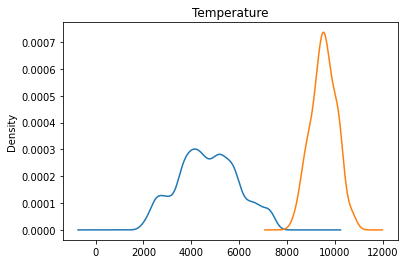

In [ ]:
normal_stars['star_temperature'].plot.density();
bright_stars['star_temperature'].plot.density(title='Temperature');

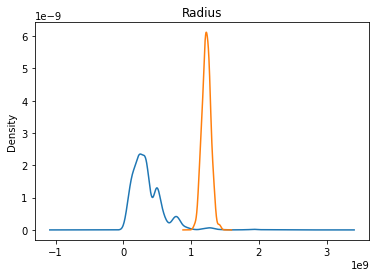

In [ ]:
normal_stars['star_radius'].plot.density();
bright_stars['star_radius'].plot.density(title='Radius');

In [ ]:
# Which are the hot bright stars?
# bright_stars = sde_stars[sde_stars['star_luminosity'] > 25]
# normal_stars = sde_stars[sde_stars['star_luminosity'] <= 25]
bright_stars = sde_stars[sde_stars['star_type_id'] == 34331]
normal_stars = sde_stars[sde_stars['star_type_id'] != 34331]
print(bright_stars['system_name'].to_numpy())
print(bright_stars['domain'].unique())

['J002216' 'J002757' 'J004317' 'J004791' 'J005834' 'J005926' 'J010569'
 'J012157' 'J012402' 'J015092' 'J001057' 'J001890' 'J002964' 'J004686'
 'J005482' 'J005900' 'J010000' 'J011321' 'J012635' 'J012735' 'J013070'
 'J013123' 'J001348' 'J001398' 'J001670' 'J002838' 'J003789' 'J004283'
 'J005923' 'J011339' 'J011563' 'J012794' 'J014348' 'J001302' 'J001769'
 'J002423' 'J002625' 'J004150' 'J004470' 'J005259' 'J005280' 'J005299'
 'J005872' 'J005969' 'J010247' 'J010556' 'J011195' 'J011355' 'J011376'
 'J011778' 'J011824' 'J001025' 'J001694' 'J001820' 'J003382' 'J003546'
 'J003793' 'J003941' 'J004128' 'J004921' 'J004998' 'J005070' 'J005223'
 'J005663' 'J005724' 'J010811' 'J011790' 'J012578' 'J012773' 'J013146'
 'J010366' 'J010951' 'J012475' 'J012686' 'J015227' 'Thera' 'J000487'
 'J000551' 'J000621' 'J000895' 'J000186' 'J000304' 'J000327' 'J000353'
 'J000452' 'J000461' 'J000522' 'J000528' 'J000595' 'J000630' 'J000965'
 'J000102' 'J000214' 'J000313' 'J000427' 'J000652' 'J000685' 'J000687'
 'J00071

In [ ]:
for col in bright_stars.columns:
  vals = len(bright_stars[col].unique())
  print(col,'=',vals)

domain = 1
region = 9
constellation = 11
system_name = 106
security = 1
solar_system_id = 106
star_id = 106
star_type_id = 1
star_age = 106
star_life = 106
star_locked = 1
star_luminosity = 106
star_radius = 106
star_spectralClass = 3
star_temperature = 106


In [ ]:
list(bright_stars['security'].unique())

[-0.99]

In [ ]:
list(bright_stars['star_type_id'].unique())

[34331]

In [ ]:
list(bright_stars['star_locked'].unique())

[False]

In [ ]:
type34 = sde_stars[sde_stars['star_type_id']==34331]
print(len(type34))

106


In [ ]:
list(bright_stars['star_spectralClass'].unique())

['A0IV', 'A0', 'A0IV2']

In [ ]:
A0IV = bright_stars[bright_stars['star_spectralClass'] == 'A0IV']
A0 = bright_stars[bright_stars['star_spectralClass'] == 'A0'] # Thera
A0IV2 = bright_stars[bright_stars['star_spectralClass'] == 'A0IV2']

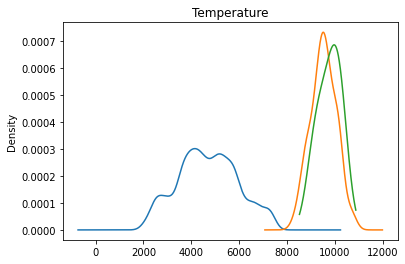

In [ ]:
normal_stars['star_temperature'].plot.density(title='Temperature');
A0IV['star_temperature'].plot.density();
A0IV2['star_temperature'].plot.density();

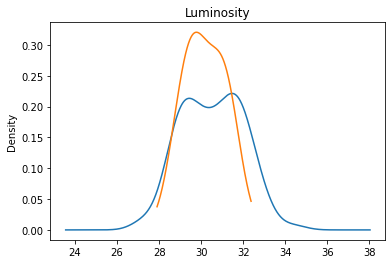

In [ ]:
A0IV['star_luminosity'].plot.density(title='Luminosity');
A0IV2['star_luminosity'].plot.density();

In [ ]:
normal_stars.describe()

,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_luminosity,star_radius,star_temperature
count,7929.000000,7.929000e+03,7.929000e+03,7929.000000,7.929000e+03,7.929000e+03,7929.000000,7.929000e+03,7929.000000
mean,-0.318592,3.031768e+07,4.024927e+07,25957.357170,4.535368e+17,9.014386e+17,0.489815,3.593022e+08,4698.299155
std,0.603728,4.636439e+05,1.417333e+05,21127.895528,4.618751e+17,7.120722e+17,1.188271,2.460101e+08,1246.278491
min,-1.000000,3.000000e+07,4.000000e+07,6.000000,6.538000e+15,9.472000e+16,0.010010,3.818500e+07,2010.000000
25%,-0.990000,3.000198e+07,4.012666e+07,3798.000000,1.265000e+17,3.314000e+17,0.029360,2.028000e+08,3815.000000
50%,-0.306624,3.000396e+07,4.025094e+07,45031.000000,2.839000e+17,6.499000e+17,0.094520,3.087000e+08,4657.000000
75%,-0.000715,3.100052e+07,4.037814e+07,45038.000000,6.306000e+17,1.291214e+18,0.403600,4.765000e+08,5585.000000
max,1.000000,3.100250e+07,4.048546e+07,45047.000000,2.873000e+18,3.077000e+18,18.570000,2.284000e+09,7496.000000


In [ ]:
bright_stars.describe()

,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_luminosity,star_radius,star_temperature
count,1.060000e+02,1.060000e+02,1.060000e+02,106.0,1.060000e+02,1.060000e+02,106.000000,1.060000e+02,106.000000
mean,-9.900000e-01,3.100241e+07,4.048803e+07,34331.0,1.503337e+16,3.144220e+16,30.512702,1.226480e+09,9541.605914
std,1.673246e-15,5.929653e+02,2.401682e+02,0.0,6.793989e+14,1.680762e+15,1.430788,6.205997e+07,516.890495
min,-9.900000e-01,3.100000e+07,4.048762e+07,34331.0,1.372426e+16,2.706883e+16,27.176355,1.059797e+09,8307.379493
25%,-9.900000e-01,3.100253e+07,4.048782e+07,34331.0,1.451541e+16,3.043356e+16,29.327555,1.188201e+09,9191.186658
50%,-9.900000e-01,3.100255e+07,4.048803e+07,34331.0,1.500486e+16,3.127447e+16,30.511095,1.223123e+09,9527.592149
75%,-9.900000e-01,3.100258e+07,4.048823e+07,34331.0,1.547099e+16,3.269967e+16,31.606368,1.264000e+09,9900.805032
max,-9.900000e-01,3.100260e+07,4.048850e+07,34331.0,1.671925e+16,3.629568e+16,34.416161,1.417298e+09,10764.116275


##The Star Plot##

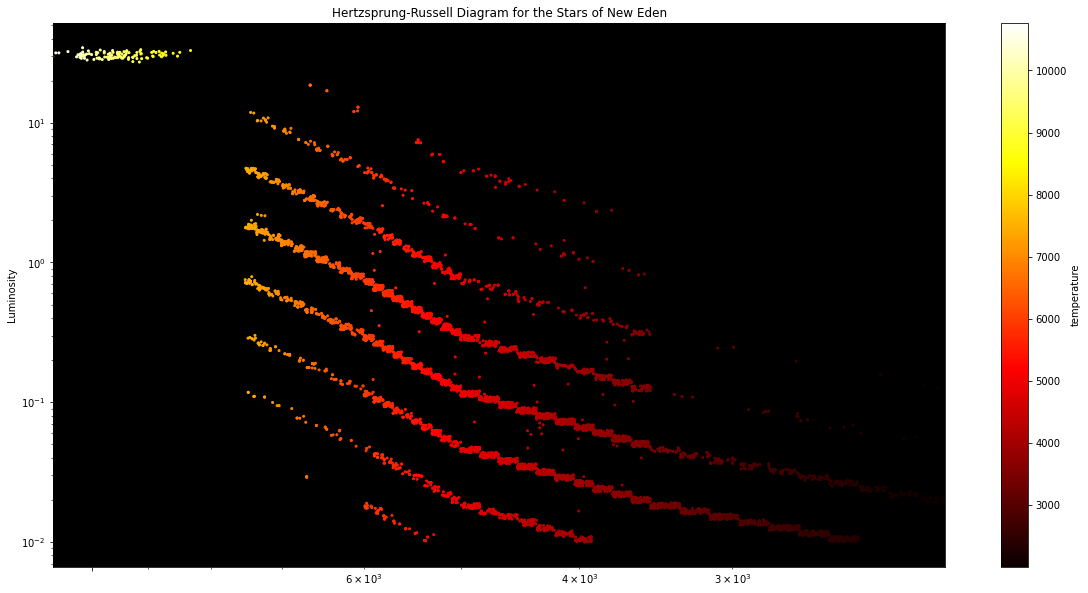

In [ ]:
# My attempt at a Hertzsprung-Russell diagram for the stars of Eve Online
# https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram

russel = star_data.plot.scatter(x='temperature', y='luminosity', figsize=(20,10), s=4, c='temperature', colormap='hot')
russel.set_title('Hertzsprung-Russell Diagram for the Stars of New Eden')
russel.set_facecolor('black')
russel.set_ylabel('Luminosity')
russel.set_xlabel('Temperature')
russel.set_yscale('log')
russel.set_xscale('log')
russel.set_xlim(star_data['temperature'].max(), star_data['temperature'].min())
russel.plot();

# convert this into a matplotlib scatter plot


# Save the figure
# fig.savefig('normal_dist1.png', transparent=False, dpi=150)


In [ ]:
sde_stars['star_temperature'].describe()

count     8035.000000
mean      4762.193432
std       1357.064515
min       2010.000000
25%       3829.500000
50%       4682.000000
75%       5628.500000
max      10764.116275
Name: star_temperature, dtype: float64

In [69]:
def blackbody_color_map(min_temp=1000, max_temp=40000, N=256):
  import re
  import pandas as pd
  import numpy as np
  from matplotlib.colors import LinearSegmentedColormap

  html = !curl http://www.vendian.org/mncharity/dir3/blackbody/UnstableURLs/bbr_color_D58.html

  #  Temp    Width  Chromacity     Power        Red    Green  Blue    Red Gre Blu  RGB Hex
  #  1000 K  10deg  0.6472 0.3506  2.525e+06    1.0000 0.0475 0.0000  255  62   0  #ff3e00
  # 40000 K  10deg  0.2460 0.2489  1.931e+17    0.2621 0.4546 1.0000  140 180 255  #8cb4ff

  pattern = '(\d{4,5}) K  10deg.+    ([\d\.]{6}) ([\d\.]{6}) ([\d\.]{6}) '
  matches = [ re.search(pattern, line) for line in html ]
  color_scale = [ match.groups() for match in matches if match ]
  column_names = ['Temp (K)','Red','Green','Blue']
  color_scale = pd.DataFrame(color_scale, columns=column_names)

  # cast string data into numbers
  color_scale['Temp (K)'] = color_scale['Temp (K)'].astype(int)
  for column in color_scale.columns[1:]:
    color_scale[column] = color_scale[column].astype(float)
  
  start_temp = np.floor(min_temp/100).astype(int)*100
  end_temp = np.ceil(max_temp/100).astype(int)*100
  temps = color_scale['Temp (K)']
  color_scale = color_scale[(temps >= start_temp) & (temps <= end_temp)]
  colors = list(color_scale[['Red','Green','Blue']].itertuples(index=False, name=None))
  color_map = LinearSegmentedColormap.from_list('blackbody_colormap', colors, N=N)
  return color_map


# star_temperature ranges from 2010 to 10764.116275
blackbody_cm = blackbody_color_map(min_temp=2010, max_temp=10764.116275, N=256)

# http://seaborn.pydata.org/tutorial/color_palettes.html
# https://en.wikipedia.org/wiki/Black-body_radiation#Black_body
# http://www.vendian.org/mncharity/dir3/blackbody/
# https://matplotlib.org/gallery/color/custom_cmap.html#sphx-glr-gallery-color-custom-cmap-py

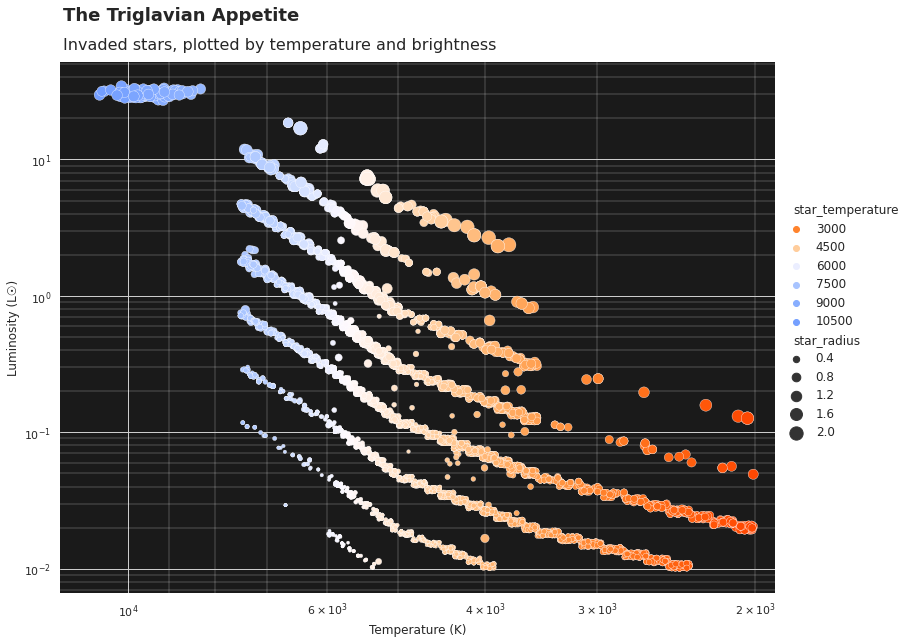

In [71]:
import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

temps = star_data['star_temperature']
min, max = (temps.min(), temps.max())
blackbody_cm = blackbody_color_map(min_temp=min, max_temp=max)

g = sns.relplot(
    data=star_data, kind='scatter',
    x='star_temperature', y='star_luminosity',
    hue='star_temperature', palette=blackbody_cm,
    size='star_radius', sizes=(10, 200),
    height=8, aspect=1.33)

#  Title and Subtitle
# titlefont = {'fontsize':18, 'weight':'bold'}
g.fig.text(s="The Triglavian Appetite",
           fontsize=18, fontweight='bold', ha='left', x=0.05, y=1.05)
g.fig.text(s='Invaded stars, plotted by temperature and brightness',
           fontsize=16, ha='left', x=0.05, y=1.00)

g.set_axis_labels(x_var='Temperature (K)', y_var='Luminosity (L☉)')
g.set(xscale='log', yscale='log', xlim=(11900, 1900))
g.ax.xaxis.grid(True, "minor", linewidth=.25, c='w')
g.ax.yaxis.grid(True, "minor", linewidth=.25, c='w')
g.ax.set_facecolor('0.1')
g.despine(left=True, bottom=True);

# https://seaborn.pydata.org/generated/seaborn.relplot.html

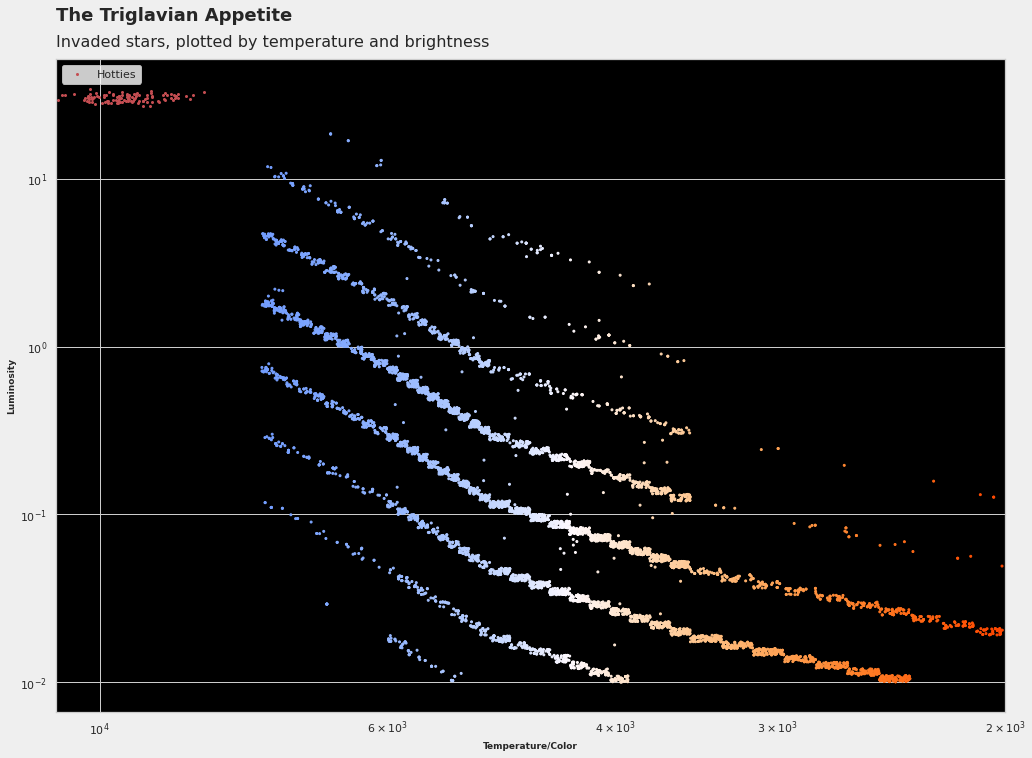

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# sde_stars
# ['domain', 'region', 'constellation', 'system_name', 'security',
      #  'solar_system_id', 'star_id', 'star_type_id', 'star_age', 'star_life',
      #  'star_locked', 'star_luminosity', 'star_radius', 'star_spectralClass',
      #  'star_temperature']

# df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/inconvenient-sequel/ratings.csv')

# get the ratings for all IMDB users
# ratings = df.iloc[-1,17:27].apply(float).to_numpy()
# index = range(1,11)

# create the figure and axis
fig = plt.figure(figsize=(17,12), facecolor='0.9375')
ax = fig.add_subplot(facecolor='0.00') #1, 1, 1, aspect=1)
grey = '0.7'  # the font and line color used throughout

ax.set_xlim(10800, 2000)
ax.set(xscale='log', yscale='log')
# ax.set_yscale('log')
# ax.set_xscale('log')


#  Title and Subtitle
titlefont = {'fontsize':18, 'weight':'bold'}
ax.set_title("The Triglavian Appetite",
             fontdict=titlefont, ha='left', x=0, y=1.05)
fig.text(s='Invaded stars, plotted by temperature and brightness',
         fontsize=16, x=0.125, y=0.895)

# fontname='Atlas Grotesk'
# ax.set_title("'An Inconvenient Sequel: Truth to Power' is divisive",
#              x=0.42, y=1.11, fontsize=13, fontweight=550)
# fig.text(s='IMDb ratings for the film as of Aug. 29', fontsize=11,
#          x=0.02, y=0.93)

# plt.xticks(index)
# plt.yticks(range(0,50,10))
# ax.set_yticklabels(labels=[0,10,20,30,'40%'])
# ax.tick_params(which='major', color=grey, labelcolor=grey)
ax.set_xlabel("Temperature/Color", fontsize=9, fontweight='bold')
ax.set_ylabel("Luminosity", fontsize=9, fontweight='bold')

# Hide the right and top spines
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_color(grey)

# ax.grid(linestyle="-", linewidth=0.5, color=grey, zorder=1)

bright_stars = sde_stars[sde_stars['star_type_id'] == 34331]
normal_stars = sde_stars[sde_stars['star_type_id'] != 34331]

# ax.bar(index, ratings, color='#ED713A', zorder=2)
ax.scatter(x=normal_stars['star_temperature'], y=normal_stars['star_luminosity'], s=4, c=normal_stars['star_temperature'], cmap=blackbody_cm)
ax.scatter(x=bright_stars['star_temperature'], y=bright_stars['star_luminosity'], s=4, c='r', label='Hotties')

# plt.scatter(x, y, s, c="g", alpha=0.5, marker=r'$\clubsuit$', label="Luck")


plt.legend(loc='upper left')

plt.show()

# Save the figure
# fig.savefig('normal_dist1.png', transparent=False, dpi=150)

# for more tricks
# https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.scatter.html
# for other colormaps
# https://matplotlib.org/examples/color/colormaps_reference.html

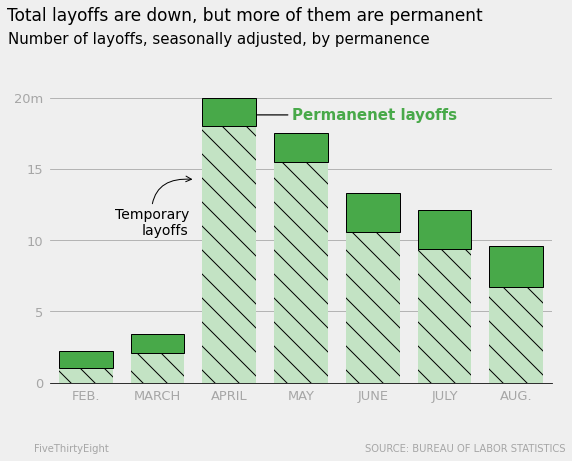

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionStyle

# Create the Figure and Axis
fig = plt.figure(figsize=(9, 5.5), facecolor='0.9375')
ax = fig.add_subplot(facecolor='0.9375', xlim=(-0.5,6.5))
fte_grey = '0.65'  # the font and line color used throughout
full_green = '#48A949'

#  Title and Subtitle
titlefont = {'fontsize':17, 'weight':550}
ax.set_title("Total layoffs are down, but more of them are permanent",
             fontdict=titlefont, ha='left', x=-0.085, y=1.19)
fig.text(s='Number of layoffs, seasonally adjusted, by permanence',
         fontsize=15, x=0.06, y=0.98)
# Font Atlas Grotesk.

# Axis Ticks
plt.xticks(range(7))
plt.yticks(range(0,25,5))
plt.tick_params(reset=True, axis='both', which='both',
                bottom=False, top=False, right=False, left=False)
# Spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Axis Labels
axisfont = {'family':'sans-serif','fontsize':13, 'color':fte_grey}
x_labels = ['FEB.','MARCH','APRIL','MAY','JUNE','JULY','AUG.']
ax.set_xticklabels(labels=x_labels, fontdict=axisfont)
y_labels = np.linspace(0,20, num=5, endpoint=True, dtype='int').astype('str')
y_labels[-1] += 'm'
ax.set_yticklabels(labels=y_labels, fontdict=axisfont)
# The axis looks like Decima Mono X, Decima Mono X Bold, Decima Mono Pro, or Decima Mono.

# Gridlines
ax.grid(linestyle="-", linewidth=0.8, color=fte_grey, axis='y', zorder=1)

# Bar Plots
ind = range(7)
temp_layoffs = [1.0, 2.1, 18., 15.5, 10.6, 9.4, 6.7]
perm_layoffs = [1.2, 1.3, 2.0, 2.0, 2.7, 2.7, 2.9]
hatches = '\\'
# ax.lines = {'lw':2, 'color':'#C3E3C4'}
plt.bar(ind, temp_layoffs, width=0.75, color='#C3E3C4', zorder=2, hatch='\\')
plt.bar(ind, perm_layoffs, width=0.75, color=full_green, zorder=3,
        bottom=temp_layoffs, edgecolor='k', linewidth=1)
# I'd really love to get the hashed lower bar to match better, but I'm
# not finding much in the docs to allow it.

# Annotations
curve = ConnectionStyle('arc3',	rad=-0.6)
arrow = {'arrowstyle':'->', 'connectionstyle':curve, 'color':'black'}
ax.annotate('Temporary\nlayoffs', xy=(0.34, 0.61), xytext=(0.33, 0.49), 
            xycoords='figure fraction', fontsize=14,
            ha='right', arrowprops=arrow)

line = {'arrowstyle':'-', 'lw':1.2}
ax.annotate('Permanenet layoffs', xy=(0.445, 0.75), xytext=(0.51, 0.74), 
            xycoords='figure fraction', fontsize=15, fontweight='bold',
            color=full_green, ha='left', arrowprops=line)

# Credits
creditfont = {'fontsize':10, 'color':fte_grey}
fig.text(s='FiveThirtyEight', fontdict=creditfont, x=0.10, y=-0.05)
fig.text(s='SOURCE: BUREAU OF LABOR STATISTICS', fontdict=creditfont,
         ha='right', x=0.92, y=-0.05)

plt.show()

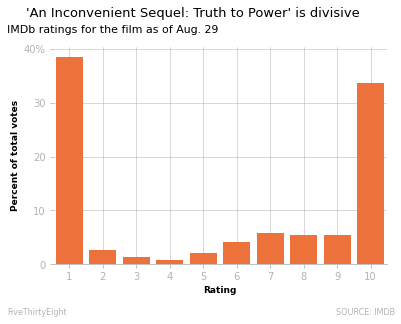

In [ ]:
# Import the data for the graph
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/inconvenient-sequel/ratings.csv')

import matplotlib.pyplot as plt

# get the ratings for all IMDB users
ratings = df.iloc[-1,17:27].apply(float).to_numpy()
index = range(1,11)

# create the figure and axis
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot() #1, 1, 1, aspect=1)

ax.set_xlim(0.5, 10.5)

grey = '0.7'  # the font and line color used throughout

plt.xticks(index)
plt.yticks(range(0,50,10))
ax.set_yticklabels(labels=[0,10,20,30,'40%'])
ax.tick_params(which='major', color=grey, labelcolor=grey)
ax.set_xlabel("Rating", fontsize=9, fontweight='bold')
ax.set_ylabel("Percent of total votes", fontsize=9, fontweight='bold')

# Hide the right and top spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(grey)

ax.grid(linestyle="-", linewidth=0.5, color=grey, zorder=1)

ax.bar(index, ratings, color='#ED713A', zorder=2)

# fontname='Atlas Grotesk'
ax.set_title("'An Inconvenient Sequel: Truth to Power' is divisive",
             x=0.42, y=1.11, fontsize=13, fontweight=550)
fig.text(s='IMDb ratings for the film as of Aug. 29', fontsize=11,
         x=0.02, y=0.93)

creditfont = {'fontsize':8, 'color':grey}
fig.text(s='FiveThirtyEight', fontdict=creditfont, x=0.02, y=-0.05)
fig.text(s='SOURCE: IMDB', fontdict=creditfont, x=0.78, y=-0.05)

fig.show()
# https://www.myfonts.com/WhatTheFont/forum/case/728911/

##Looking in the ESI for Invasion Data##
Incursions: Sansha's Nation, 4 Incursions, 26 systems

Faction Warfare: Only the main 4 empires

In [ ]:
# Connect to the ESI API.
!pip install bravado
from bravado.client import SwaggerClient
import bravado.exception
client = SwaggerClient.from_url('https://esi.evetech.net/_latest/swagger.json?datasource=tranquility')

# Make a dictionary for faction_id to faction name
result = client.Universe.get_universe_factions().result()

# https://pypi.org/project/bravado/
# https://esi.evetech.net/ui  # available EVE data

In [ ]:
# This table of Faction IDs comes in handy
faction_name_from_id = {f.faction_id : f.name for f in result}
print('FactionIDs')
for key in sorted(faction_name_from_id):
  print(key,'=',faction_name_from_id[key])

FactionIDs
500001 = Caldari State
500002 = Minmatar Republic
500003 = Amarr Empire
500004 = Gallente Federation
500005 = Jove Empire
500006 = CONCORD Assembly
500007 = Ammatar Mandate
500008 = Khanid Kingdom
500009 = The Syndicate
500010 = Guristas Pirates
500011 = Angel Cartel
500012 = Blood Raider Covenant
500013 = The InterBus
500014 = ORE
500015 = Thukker Tribe
500016 = Servant Sisters of EVE
500017 = The Society of Conscious Thought
500018 = Mordu's Legion Command
500019 = Sansha's Nation
500020 = Serpentis
500021 = Unknown
500024 = Drifters
500025 = Rogue Drones
500026 = Triglavian Collective
500027 = EDENCOM


In [ ]:
# ['constellation_id', 'faction_id', 'has_boss', 'infested_solar_systems', 
# 'influence', 'staging_solar_system_id', 'state', 'type']

result = client.Incursions.get_incursions().result()
faction_ids = set([faction.faction_id for faction in result])
for id in faction_ids:
  print(faction_name_from_id[id])

# flat_list = [item for sublist in nested_list for item in sublist]
infested_systems = [system for incursion in incursions for system in incursion['infested_solar_systems']]
names = [client.Universe.get_universe_systems_system_id(system_id = system).result().name for system in infested_systems]
print('Infested systems:',names)

# add infested stars to star_data
star_data['sansha_incursion'] = star_data['solar_system_id'].isin(infested_systems)

Sansha's Nation
Infested systems: ['Amafi', 'Hakana', 'Ashkoo', 'Baratar', 'Arzieh', 'Nahrneder', '4S0-NP', 'K-RMI5', 'C-6YHJ', 'M53-1V', 'E5T-CS', 'W4C8-Q', 'I-2705', 'GM-50Y', 'G9L-LP', 'MLQ-O9', 'L-FM3P', 'X-ARMF', '8-OZU1', '0TYR-T', 'Paara', 'Annaro', 'Isutaka', 'Tasabeshi', 'Ono', 'Muvolailen']


In [ ]:
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,sansha_incursion
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,False
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,False
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,False
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,False
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,False
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,False
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,False
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,False


In [ ]:
star_data[star_data['system_name'] == 'Niarja']

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,sansha_incursion
1187,eve,Domain,Yekti,Niarja,0.541992,30003504,40222373,3801,8.701000e+16,2.456000e+17,False,0.3235,163200000.0,F9 VI,6057.0,False


In [ ]:
niarja = client.Universe.get_universe_systems_system_id(system_id = 30003504).result()

for key in niarja:
  print(key,'=',niarja[key])

star_data[star_data['system_name'] == 'Niarja']

constellation_id = 20000788
name = Niarja
planets = [get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222374), get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222375), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222378], planet_id=40222377), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222380, 40222381], planet_id=40222379), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222383, 40222384, 40222386, 40222387, 40222388, 40222389, 40222390, 40222391, 40222392, 40222393, 40222394, 40222395], planet_id=40222382), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222397, 40222398, 40222399, 40222400, 40222401, 40222402, 40222403, 40222404, 40222405, 40222406], planet_id=40222396), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222408, 40222409], planet_id=40222407), get_universe_systems_system_id_planet(asteroid_belts=

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
1187,eve,Domain,Yekti,Niarja,0.541992,30003504,40222373,3801,8.701000e+16,2.456000e+17,False,0.3235,163200000.0,F9 VI,6057.0


In [ ]:
# from zKillBoard
# {'constellationID': 20000788,
#    'constellationName': 'Krai Svarog',
#    'id': 30003504,
#    'kills': 409,
#    'name': 'Niarja',
#    'regionID': None,
#    'solarSystemID': 30003504,
#    'solarSystemName': 'Niarja',
#    'solarSystemSecurity': '-1.0',
#    'sunTypeID': 56085,
#    'systemColorCode': '#F30202',
#    'typeID': None},

In [ ]:
# Factions involved in Faction Warfare
result = client.Faction_Warfare.get_fw_stats().result()
faction_ids = [faction.faction_id for faction in result]
for id in faction_ids:
  print(faction_name_from_id[id])

Caldari State
Minmatar Republic
Amarr Empire
Gallente Federation


In [ ]:
# Wars
war_ids = client.Wars.get_wars().result()
client.Wars.get_wars_war_id(war_id = war_ids[0]).result()

get_wars_war_id_ok(aggressor=get_wars_war_id_aggressor(alliance_id=99009475, corporation_id=None, isk_destroyed=0.0, ships_killed=0), allies=[], declared=datetime.datetime(2020, 9, 21, 20, 53, tzinfo=tzlocal()), defender=get_wars_war_id_defender(alliance_id=None, corporation_id=98509823, isk_destroyed=0.0, ships_killed=0), finished=None, id=691541, mutual=False, open_for_allies=False, retracted=None, started=datetime.datetime(2020, 9, 22, 20, 53, tzinfo=tzlocal()))

In [ ]:
# Corps
corp_ids = client.Corporation.get_corporations_npccorps().result()
for id in corp_ids:
  corp = client.Corporation.get_corporations_corporation_id(corporation_id = id).result()
  print(corp.name,'has',corp.member_count,'members')

CBD Corporation has 154 members
Ytiri has 85 members
Deep Core Mining Inc. has 206607 members
Minedrill has 55 members
Kaalakiota Corporation has 159 members
Top Down has 25 members
Perkone has 182053 members
Zainou has 37 members
Echelon Entertainment has 34 members
Lai Dai Corporation has 80 members
Propel Dynamics has 34 members
CBD Sell Division has 33 members
Caldari Constructions has 86 members
Caldari Funds Unlimited has 31 members
Modern Finances has 48 members
Mercantile Club has 34 members
House of Records has 20 members
Internal Security has 14 members
Ishukone Watch has 38 members
Peace and Order Unit has 35 members
Wiyrkomi Peace Corps has 19 members
School of Applied Knowledge has 1138721 members
Sebiestor Tribe has 136330 members
Vherokior Tribe has 37 members
Republic Parliament has 83 members
Republic Justice Department has 87 members
Republic Security Services has 121 members
Core Complexion Inc. has 158 members
Eifyr and Co. has 15 members
Native Freshfood has 64721 

KeyboardInterrupt: ignored

In [ ]:
properties = [*corp]

print(properties)
properties = ['alliance_id', 'ceo_id', 'creator_id', 'date_founded', 'description', 'faction_id', 'home_station_id', 'member_count', 'name', 'shares', 'tax_rate', 'ticker', 'url', 'war_eligible']


for item in corp:
  print(item,'=',corp[item])

['alliance_id', 'ceo_id', 'creator_id', 'date_founded', 'description', 'faction_id', 'home_station_id', 'member_count', 'name', 'shares', 'tax_rate', 'ticker', 'url', 'war_eligible']
alliance_id = None
ceo_id = 3019525
creator_id = 1
date_founded = None
description = An offshoot of the Imperial Shipment corporation, originally formed to provide planetary security for the shipping giant on frontier worlds and new colonies. Ametat Security now offers troops and equipment to anyone willing to pay their rates.
faction_id = None
home_station_id = 60007171
member_count = 174589
name = Ametat Security
shares = 0
tax_rate = 0.0
ticker = AMESE
url = None
war_eligible = None


In [ ]:
# Opportunity Descriptions
op_ids = client.Opportunities.get_opportunities_groups().result()
for id in op_ids:
  op = client.Opportunities.get_opportunities_groups_group_id(group_id = id).result()
  print(op.description)

As a capsuleer, you gain new abilities by training skills. You will eventually unleash the full capabilities of your mind. <br><br>As you train skills, pathways in your brain become more advanced, giving you access to new ships, modules and activities. Starting a skill training now would be a great first step in your new life.
In space, situational awareness is the key to your survival. Let me show you how to become aware and alert.
As a capsuleer, your mind is directly connected to your ship. Your thoughts are its commands. Its damage is your pain. Your piloting skills will be vital in your future career. <br><br>Currently there are hostile ships in your area that are part of a rogue cloning gang. We should get you into position to take them out and remove their threat from the system.
The nearby hostiles are a threat to your empire's capsuleer training program. This is a secure system and their presence is unwanted and poses a risk to civilians. <br><br>By removing this threat you wi

In [ ]:
# Task Descriptions
tsk_ids = client.Opportunities.get_opportunities_tasks().result()
for id in tsk_ids:
  tsk = client.Opportunities.get_opportunities_tasks_task_id(task_id = id).result()
  print(tsk.description)

<b>Wait for your mining laser cycle to finish at least three cycles.</b> It may take a little more time, but why not take the time to fill up your cargo hold and get back to station once you are done to make some money from your hard labor.
It's often a good idea to trade items between star systems, since prices vary based on supply and demand. Star systems in New Eden are connected by stargates.<br><br>Move your minerals from the hangar to your ship's cargo hold. This is the cargo you will be selling in another star system.<br><br><b>Undock and look for a stargate in your Overview. You can identify it by the icon shown below, and use it to jump to another system.</b> Use the radial menu to fly to a stargate and jump through.
To use station services you will have to dock. <b>Find the station icon in space or in your Overview. Use the radial menu to issue the dock command.</b> Once you are close enough, the automatic docking procedure will start.
You will notice that ships have three la

In [ ]:
# Get player count
players = client.Status.get_status().result().players
print('There are',format(players,',d'),'players in Eve right now!')

There are 29,104 players in Eve right now!


In [ ]:
war_ids = client.Wars.get_wars().result()
a_war = client.Wars.get_wars_war_id(war_id = war_ids[0]).result()

# Get a list of keys in a dictionary-like object
# Does Work
properties = [*a_war]  # Fastest
# properties = list(a_war) # Slightly slower
# properties = [keyword for keyword in a_war]

# Doesn't work
# properties = **a_war
# properties = *a_war

print(properties)

for item in a_war:
  print(item,'=',a_war[item])

['aggressor', 'allies', 'declared', 'defender', 'finished', 'id', 'mutual', 'open_for_allies', 'retracted', 'started']
aggressor = get_wars_war_id_aggressor(alliance_id=99007160, corporation_id=None, isk_destroyed=0.0, ships_killed=0)
allies = []
declared = 2020-09-29 19:45:00+00:00
defender = get_wars_war_id_defender(alliance_id=None, corporation_id=98610020, isk_destroyed=0.0, ships_killed=0)
finished = None
id = 691546
mutual = False
open_for_allies = False
retracted = None
started = 2020-09-30 19:45:00+00:00


In [ ]:
import pandas as pd

corp_ids = client.Corporation.get_corporations_npccorps().result()
corp = client.Corporation.get_corporations_corporation_id(corporation_id=corp_ids[0]).result()
keys = [*corp]
# ['alliance_id', 'ceo_id', 'creator_id', 'date_founded', 'description', 'faction_id', 'home_station_id', 'member_count', 'name', 'shares', 'tax_rate', 'ticker', 'url', 'war_eligible']

corps = {key:[] for key in keys}
for i, id in enumerate(corp_ids):
  corp = client.Corporation.get_corporations_corporation_id(corporation_id=id).result()
  for key in corp:
    # print(key,'=',corp[key])
    corps[key].append(corp[key])
  print(format(i/len(corp_ids),'.2f'),'-',corp.name)
corps = pd.DataFrame(data = corps)

corps['description'] = corps['description'].replace({None:''})

0.00 - CBD Corporation
0.00 - Ytiri
0.01 - Deep Core Mining Inc.
0.01 - Minedrill
0.02 - Kaalakiota Corporation
0.02 - Top Down
0.02 - Perkone
0.03 - Zainou
0.03 - Echelon Entertainment
0.03 - Lai Dai Corporation
0.04 - Propel Dynamics
0.04 - CBD Sell Division
0.05 - Caldari Constructions
0.05 - Caldari Funds Unlimited
0.05 - Modern Finances
0.06 - Mercantile Club
0.06 - House of Records
0.06 - Internal Security
0.07 - Ishukone Watch
0.07 - Peace and Order Unit
0.08 - Wiyrkomi Peace Corps
0.08 - School of Applied Knowledge
0.08 - Sebiestor Tribe
0.09 - Vherokior Tribe
0.09 - Republic Parliament
0.10 - Republic Justice Department
0.10 - Republic Security Services
0.10 - Core Complexion Inc.
0.11 - Eifyr and Co.
0.11 - Native Freshfood
0.11 - The Leisure Group
0.12 - Carthum Conglomerate
0.12 - Viziam
0.13 - Noble Appliances
0.13 - HZO Refinery
0.13 - Imperial Shipment
0.14 - Joint Harvesting
0.14 - Further Foodstuffs
0.15 - Imperial Chancellor
0.15 - Ministry of War
0.15 - Ministry of I

In [ ]:
corps

,alliance_id,ceo_id,creator_id,date_founded,description,faction_id,home_station_id,member_count,name,shares,tax_rate,ticker,url,war_eligible
0,None,3004049,1,None,The CBD Corporation is one of the biggest expo...,NaN,60000004,154,CBD Corporation,30515077373,0.00,CBDC,None,None
1,None,3004217,1,None,Ytiri is a rare example of an outsider company...,NaN,60000310,85,Ytiri,3495338567,0.00,Y,None,None
2,None,3004089,1,None,Deep Core Mining is a young company that was f...,NaN,60000610,206607,Deep Core Mining Inc.,1319961277,0.11,DCMI,None,None
3,None,3004145,1,None,Minedrill traces its history back to the war w...,NaN,60000766,55,Minedrill,7843253908,0.00,M,None,None
4,None,3004129,1,None,"The largest of the Caldari mega corporations, ...",NaN,60000976,159,Kaalakiota Corporation,35200134523,0.00,KC,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,None,0,1,None,Codename: Scylla Infestation\r\r\n\r\r\nCONCOR...,NaN,0,0,Scylla Infestation,0,0.00,SCYLI,None,None
258,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Perun Clade,0,0.00,CLPER,None,None
259,None,3019611,1,None,CONCORD's Authority for Emergency Interdiction...,NaN,60012916,1,AEGIS,0,0.00,COAEG,None,None
260,None,1,1,None,"A wealth creation, resource exchange and data ...",NaN,60002245,0,PKN Cryptographic,0,0.00,PKNCG,None,None


In [ ]:
suspects

,alliance_id,ceo_id,creator_id,date_founded,description,faction_id,home_station_id,member_count,name,shares,tax_rate,ticker,url,war_eligible
124,None,0,1,None,The Navka Overminds are a form of rogue drone ...,NaN,0,0,Navka Overminds,0,0.0,NAVKA,None,None
126,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Veles Clade,0,0.0,CLVEL,None,None
127,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Svarog Clade,0,0.0,CLSVA,None,None
128,None,1,1,None,The Convocation of Triglav Outside the Struggl...,NaN,60000001,0,The Convocation of Triglav,0,0.0,CTPSV,None,None
256,None,0,1,None,The motives of the Unshackled Overminds are ob...,NaN,0,0,Unshackled Overminds,0,0.0,UNOVM,None,None
258,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Perun Clade,0,0.0,CLPER,None,None
259,None,3019611,1,None,CONCORD's Authority for Emergency Interdiction...,NaN,60012916,1,AEGIS,0,0.0,COAEG,None,None


In [ ]:
suspects = corps[corps['description'].str.contains("Trigl")]

for name, desc in zip(suspects['name'],suspects['description']):
  print(name+': '+desc,'\n\n')



It would seem that the Navka Overminds are either entirely suborned to Triglavian purposes or, perhaps more worryingly, are willingly working with them. 




The Veles Clade seems to be made up of many subclades and is seemingly very strong in the fields of heavy space industry, communications technology and high-energy exotic particle physics. The Veles Clade seems to prize discourse and diplomacy, after a fashion, over strife â€“ that is, if the evidence has been understood correctly. 




The Svarog Clade is apparently made up of many subclades and the evidence so far indicates strengths in combat vessel construction, the development of novel weapon systems and extensive use of bioadaptive mutaplasmid technology. The Svarog Clade seems the most aggressive and traditional, while inclined to explore new opportunities. 


The Convocation of Triglav: The Convocation of Triglav Outside the Struggle appears to be a central organizing body for the Triglavian Collective. Data recovered fr

## Kill Data from zKillBoard ##

In [ ]:
# Try the zkillboard api first
# https://github.com/zKillboard/zKillboard/wiki

# If all else fails, there lots of data for webscraping
# https://zkillboard.com/faction/500026/

In [2]:
import yaml

try:
  response = !curl https://zkillboard.com/api/stats/factionID/500026/
  trig_kills = yaml.safe_load(response[0])
except yaml.YAMLError as exc:
  print(exc)

for key in sorted(trig_kills):
  print(key+':',trig_kills[key])

activepvp: {'ships': {'type': 'Ships', 'count': 48}, 'systems': {'type': 'Systems', 'count': 37}, 'regions': {'type': 'Regions', 'count': 16}, 'kills': {'type': 'Total Kills', 'count': 450}}
allTimeSum: 40722
attackersDestroyed: 153772
gangRatio: 74
groups: {'25': {'groupID': 25, 'shipsDestroyed': 4693, 'pointsDestroyed': 25492, 'iskDestroyed': 105791385163}, '26': {'groupID': 26, 'shipsDestroyed': 11225, 'pointsDestroyed': 96522, 'iskDestroyed': 802151061458}, '27': {'groupID': 27, 'shipsDestroyed': 2554, 'pointsDestroyed': 99359, 'iskDestroyed': 1955166093164}, '28': {'groupID': 28, 'shipsDestroyed': 762, 'pointsDestroyed': 1868, 'iskDestroyed': 28846829285}, '29': {'groupID': 29, 'shipsDestroyed': 1837, 'pointsDestroyed': 1837, 'iskDestroyed': 27382242253}, '31': {'groupID': 31, 'shipsDestroyed': 45, 'pointsDestroyed': 45, 'iskDestroyed': 9752801}, '237': {'groupID': 237, 'shipsDestroyed': 964, 'pointsDestroyed': 1021, 'iskDestroyed': 2776261516}, '324': {'groupID': 324, 'shipsDestr

In [ ]:
# Triglavian Kills in "topAllTime: ship"
  
ship_data = trig_kills['topAllTime'][4]['data']  # 5 = system level
kills =          [ship['kills'] for ship in ship_data]
shipTypeIDs = [ship['shipTypeID'] for ship in ship_data]
ship_kills = pd.DataFrame({'kills':kills, 'shipTypeID':shipTypeIDs})

total_kills = format(ship_kills['kills'].sum(),',d')
count = len(ship_kills['shipTypeID'].unique())
print('"topAllTime: ship" lists',total_kills,'total kills from',count,'unique ships')

ship_kills

"topAllTime: ship" lists 113,421 total kills from 100 unique ships


,kills,shipTypeID
0,38032,47465
1,37828,54577
2,5880,52645
3,5483,52649
4,2194,52646
...,...,...
95,20,52701
96,16,52473
97,14,54204
98,13,54568


In [61]:
# Triglavian Kills in "topAllTime: system"
import pandas as pd

# for i, item in enumerate(trig_kills['topAllTime']):
#   print(i,'=',item['type'])
# 0 = character
# 1 = corporation
# 2 = alliance
# 3 = faction
# 4 = ship
# 5 = system

system_data = trig_kills['topAllTime'][5]['data']  # 5 = system level
kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_kills = pd.DataFrame({'triglavian_kills':kills, 'solarSystemID':solarSystemIDs})

total_kills = format(system_kills['triglavian_kills'].sum(),',d')
count = len(system_kills['solarSystemID'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

system_kills

"topAllTime: system" lists 60,899 total kills in 100 unique systems


,triglavian_kills,solarSystemID
0,6695,30003504
1,3616,30000182
2,2924,30001391
3,2397,30001447
4,2314,30001401
...,...,...
95,208,32000184
96,207,32000089
97,207,32000091
98,207,32000191


In [62]:
test = star_data.merge(system_kills, how='left', left_on='solar_system_id', right_on='solarSystemID',)
test.drop(labels='solarSystemID', axis=1, inplace=True)
# test.domain.value_counts()
test

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,triglavian_kills
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,NaN
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,NaN
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,NaN
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,NaN


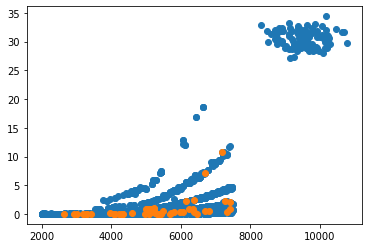

In [68]:
trig_stars = test[test.triglavian_kills > 0]
plt.scatter(x=test.star_temperature, y=test.star_luminosity)
plt.scatter(x=trig_stars.star_temperature, y=trig_stars.star_luminosity)

In [48]:
systemid_to_name = pd.Series(star_data.system_name.values,index=star_data.solar_system_id).to_dict()

def solarID_to_sde_name(solar_system_id):
  # if ID is present in star_data, return the name from there
  if solar_system_id in star_data['solar_system_id'].values:
    return systemid_to_name[solar_system_id]

  # or get it from the abyssal and penalty sde systems
  elif str(solar_system_id) in list(system_data['system_name']):
    return str(solar_system_id)

  else:
    return np.nan

def solarID_to_esi_name(solar_system_id):
  # if ID is present in star_data, return the name from there
  if solar_system_id in star_data['solar_system_id'].values:
    return systemid_to_name[solar_system_id]

  # else look it up in the ESI
  else:
    try:
      system = client.Universe.get_universe_systems_system_id(system_id=solar_system_id).result()
      return system.name

    except:
      return np.nan

system_kills['sde_name'] = system_kills['solar_system_id'].apply(solarID_to_sde_name)
system_kills['esi_name'] = system_kills['solar_system_id'].apply(solarID_to_esi_name)
system_kills
# for solar_id in system_kills['solar_system_id']:
#   name = solarID_to_name(solar_id)
#   print(solar_id,'=',name)

,kills,solar_system_id,sde_name,esi_name
0,6695,30003504,Niarja,Niarja
1,3616,30000182,Inaya,Inaya
2,2924,30001391,Piekura,Piekura
3,2397,30001447,Taisy,Taisy
4,2314,30001401,Nonni,Nonni
...,...,...,...,...
95,208,32000184,32000184,AD184
96,207,32000089,32000089,AD089
97,207,32000091,32000091,AD091
98,207,32000191,32000191,AD191


In [ ]:
system_kills = system_kills.merge(star_data[['solar_system_id','system_name']], how='inner',
                                  left_on='solar_system_id', right_on='solar_system_id')
system_kills

,kills,solar_system_id,system_name_x,system_name_y
0,6695,30003504,Niarja,Niarja
1,3616,30000182,Inaya,Inaya
2,2924,30001391,Piekura,Piekura
3,2397,30001447,Taisy,Taisy
4,2314,30001401,Nonni,Nonni
5,2307,30000205,Obe,Obe
6,1959,30003495,Raravoss,Raravoss
7,1866,30045329,Ichoriya,Ichoriya
8,1858,30045338,Hikkoken,Hikkoken
9,1629,30000163,Akora,Akora


In [3]:
# Download the Static Data Export (SDE) file (103 MB)
!wget https://eve-static-data-export.s3-eu-west-1.amazonaws.com/tranquility/sde.zip

--2020-10-15 17:00:31--  https://eve-static-data-export.s3-eu-west-1.amazonaws.com/tranquility/sde.zip
Resolving eve-static-data-export.s3-eu-west-1.amazonaws.com (eve-static-data-export.s3-eu-west-1.amazonaws.com)... 52.218.91.96
Connecting to eve-static-data-export.s3-eu-west-1.amazonaws.com (eve-static-data-export.s3-eu-west-1.amazonaws.com)|52.218.91.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108734347 (104M) [application/zip]
Saving to: ‘sde.zip’

sde.zip             100%[===================>] 103.70M  25.7MB/s    in 4.0s    

2020-10-15 17:00:36 (25.7 MB/s) - ‘sde.zip’ saved [108734347/108734347]



In [24]:
# Parse and Extract data from sde.zip

from zipfile import ZipFile
import re
import numpy as np
import yaml
import pandas as pd

# from https://developers.eveonline.com/resource/resources
# https://www.geeksforgeeks.org/working-zip-files-python/

# Get solar system file paths
def getPaths(domains):
  system_file_paths = []
  with ZipFile('sde.zip', 'r') as zip:
    sde_files = zip.namelist()
    for domain in domains:
      pattern = '(^sde/fsd/universe/' +domain+ '.+/solarsystem.staticdata$)'
      matches = (re.search(pattern, line) for line in sde_files)
      system_file_paths.extend([match.group(1) for match in matches if match])
    zip.close()
  return system_file_paths

# All domains are ['abyssal', 'eve', 'penalty', 'wormhole']
system_file_paths = getPaths(['abyssal', 'eve', 'penalty', 'wormhole'])
print('Got file paths for',format(len(system_file_paths),',d'),'solar system files')

def extract_stars_from_sde():
  data = {'domain':[],
          'region':[],
          'constellation':[],
          'system_name':[]}
          
  for i, filepath in enumerate(system_file_paths):
    (_,_,_,domain,region,constellation,system_name,_) = filepath.split('/')

    # File path components
    data['domain'].append(domain if domain else None)
    data['region'].append(region if region else None)
    data['constellation'].append(constellation if constellation else None)
    data['system_name'].append(system_name if system_name else None)

  return pd.DataFrame(data)
system_data = extract_stars_from_sde()
system_data

Got file paths for 8,285 solar system files


,domain,region,constellation,system_name
0,abyssal,12000001,22000001,32000001
1,abyssal,12000001,22000001,32000002
2,abyssal,12000001,22000001,32000003
3,abyssal,12000001,22000001,32000004
4,abyssal,12000001,22000001,32000005
...,...,...,...,...
8280,wormhole,K-R00033,K-C00334,J055520
8281,wormhole,K-R00033,K-C00334,J110145
8282,wormhole,K-R00033,K-C00334,J164710
8283,wormhole,K-R00033,K-C00334,J174618


In [42]:
system_data[system_data['system_name'] == '32000107']

,domain,region,constellation,system_name
106,abyssal,12000003,22000014,32000107


In [19]:
system = client.Universe.get_universe_systems_system_id(system_id = 32000158).result()
for key in sorted(system):
  print(key,'=',system[key])

constellation_id = 22000020
name = AD158
planets = None
position = get_universe_systems_system_id_position(x=4.284860289421954e+18, y=5.160541259488124e+18, z=-6.026009229334713e+18)
security_class = None
security_status = -0.9900000095367432
star_id = None
stargates = None
stations = None
system_id = 32000158


In [28]:
system_kills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   kills            100 non-null    int64
 1   solar_system_id  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


In [27]:
format(system_kills['kills'].sum(), ',d')

'60,899'

In [8]:
# star_data
systemid_to_name = pd.Series(star_data.system_name.values,index=star_data.solar_system_id).to_dict()
systemid_to_name

{30001620: 'E-RPGP',
 30001623: 'KER-EU',
 30001622: 'NSE-U1',
 30001619: 'R79-I7',
 30001618: 'UC-X28',
 30001621: 'ZV-KZO',
 30001615: '2RV-06',
 30001614: '8U-RZH',
 30001611: 'B-Y06L',
 30001616: 'CLDT-L',
 30001610: 'DT-7EO',
 30001612: 'HHQ-8L',
 30001617: 'QU7-EE',
 30001613: 'Z-KPAR',
 30001626: '5V-YL6',
 30001624: '69A-54',
 30001627: '8-UWFS',
 30001629: 'BWO-UU',
 30001625: 'M9-OS2',
 30001628: 'PQWA-L',
 30001630: 'SQVI-U',
 30001643: '0IRK-R',
 30001642: '3-CE1R',
 30001641: '50-TJY',
 30001639: '7BA-TK',
 30001638: 'FNS3-F',
 30001637: 'FR-RCH',
 30001640: 'IAWJ-X',
 30001599: '0Z-VHC',
 30001598: '2-NF2Z',
 30001603: '6-HFD6',
 30001600: '9-BUSQ',
 30001602: 'II-1B3',
 30001601: 'LQB-TC',
 30001632: 'DLY-RG',
 30001635: 'F-KBNV',
 30001636: 'JL-P9P',
 30001633: 'T-C5A0',
 30001631: 'T-YWDD',
 30001634: 'UP-L3Y',
 30001608: '7-8XK0',
 30001609: '90G-OA',
 30001606: 'FX-XMW',
 30001607: 'G-N6MC',
 30001605: 'LCN-0V',
 30001604: 'P3UD-M',
 30004238: 'Gens',
 30004240: 'Hie

In [ ]:
# Triglavian Kills in "topLists: solarSystem"
import pandas as pd

# for i, item in enumerate(trig_kills['topLists']):
#   print(i,'=',item['type'])
# 0 = character
# 1 = corporation
# 2 = alliance
# 3 = shipType
# 4 = solarSystem
# 5 = location

system_data = trig_kills['topLists'][4]['values']  # 4 = system level

kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_top_kills = pd.DataFrame({'kills':kills, 'solarSystemID':solarSystemIDs})

total_kills = format(system_top_kills['kills'].sum(),',d')
count = len(system_top_kills['solarSystemID'].unique())
print('"topLists: solarSystem" lists',total_kills,'total kills in',count,'unique systems')

system_top_kills

"topLists: solarSystem" lists 915 total kills in 10 unique systems


,kills,solarSystemID
0,391,30003504
1,174,30001400
2,70,30001391
3,45,30005330
4,45,30000163
5,44,30001401
6,40,30003495
7,36,30020141
8,35,30045354
9,35,30010141


In [ ]:
# Triglavian Kills by Months
import pandas as pd

month_yaml = trig_kills['months']  # 5 = system level
month_data = {}
month_data['iskDestroyed'] = [month_yaml[key]['iskDestroyed'] for key in month_yaml]
month_data['shipsDestroyed'] = [month_yaml[key]['shipsDestroyed'] for key in month_yaml]
month_data['years'] = [month_yaml[key]['year'] for key in month_yaml]
month_data['months'] = [month_yaml[key]['month'] for key in month_yaml]
month_data = pd.DataFrame(month_data)

total_kills = format(month_data['shipsDestroyed'].sum(),',d')
total_isk =   format(month_data['iskDestroyed'].sum(),',d')
count = len(month_yaml)
print('"months" lists',total_kills,'total kills and',total_isk,'total isk lost over',count,'months')

month_data

"months" lists 40,856 total kills and 5,165,829,584,055 total isk lost over 14 months


,iskDestroyed,shipsDestroyed,years,months
0,43548904493,70,2019,9
1,172835382075,272,2019,10
2,234680330045,348,2019,11
3,429766211232,564,2019,12
4,331170373343,454,2020,1
5,139203207114,191,2020,2
6,95073168442,138,2020,3
7,112219189021,195,2020,4
8,198230305417,710,2020,5
9,128912150771,782,2020,6


In [ ]:
# Triglavian Kills by Ship GroupID

import pandas as pd

group_data = trig_kills['groups']  # 5 = system level
kills =   [group_data[group]['shipsDestroyed'] for group in group_data]
groupID = [group_data[group]['groupID'] for group in group_data]
group_kills = pd.DataFrame({'groupID':groupID, 'shipsDestroyed':kills})

total_kills = format(group_kills['shipsDestroyed'].sum(),',d')
count = len(group_kills['groupID'].unique())
print('"groups" lists',total_kills,'total kills in',count,'unique groupIDs')

group_kills.head()

"groups" lists 40,856 total kills in 44 unique groupIDs


,groupID,shipsDestroyed
0,25,4693
1,26,11224
2,27,2553
3,28,762
4,29,1837


In [ ]:
print('Total Triglavian Kills:\n')

# allTimeSum
total_kills = format(trig_kills['allTimeSum'],',d')
print('"allTimeSum" says there are',total_kills,'total kills.')

# iskDestroyed
total_isk = format(trig_kills['iskDestroyed'], ',d')
print('"iskDestroyed" says a total of',total_isk,'has been lost.')

# shipsDestroyed
total_kills = format(trig_kills['shipsDestroyed'],',d')
print('"shipsDestroyed" says there are',total_kills,'total kills.')

# topAllTime: system
total_kills = format(system_kills['kills'].sum(),',d')
count = len(system_kills['solar_system_id'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

# topAllTime: ship
total_kills = format(ship_kills['kills'].sum(),',d')
count = len(ship_kills['shipTypeID'].unique())
print('"topAllTime: ship" lists',total_kills,'total kills from',count,'unique ships')

# topLists: solarSystem
total_kills = format(system_top_kills['kills'].sum(),',d')
count = len(system_top_kills['solarSystemID'].unique())
print('"topLists: solarSystem" lists',total_kills,'total kills in',count,'unique systems')

# months
total_kills = format(month_data['shipsDestroyed'].sum(),',d')
total_isk =   format(month_data['iskDestroyed'].sum(),',d')
count = len(month_yaml)
print('"months" lists',total_kills,'total kills and',total_isk,'total isk lost over',count,'months')

# ship groups
total_kills = format(group_kills['shipsDestroyed'].sum(),',d')
count = len(group_kills['groupID'].unique())
print('"groups" lists',total_kills,'total kills from',count,'unique ship groupIDs')

Total Triglavian Kills:

"allTimeSum" says there are 40,722 total kills.
"iskDestroyed" says a total of 5,165,829,584,063 has been lost.
"shipsDestroyed" says there are 40,856 total kills.
"topAllTime: system" lists 60,899 total kills in 100 unique systems
"topAllTime: ship" lists 113,421 total kills from 100 unique ships
"topLists: solarSystem" lists 915 total kills in 10 unique systems
"months" lists 40,856 total kills and 5,165,829,584,055 total isk lost over 14 months
"groups" lists 40,856 total kills from 44 unique ship groupIDs


In [ ]:
# Different sources disagree over Niarja's basics

niarja = client.Universe.get_universe_systems_system_id(system_id = 30003504).result()
for key in sorted(niarja):
  print(key,'=',niarja[key])

# From SDE.zip
star_data[star_data['system_name'] == 'Niarja']

# From zKillBoard
# {'constellationID': 20000788,
#   'constellationName': 'Krai Svarog',
#   'id': 30003504,
#   'kills': 409,
#   'name': 'Niarja',
#   'regionID': None,
#   'solarSystemID': 30003504,
#   'solarSystemName': 'Niarja',
#   'solarSystemSecurity': '-1.0',
#   'sunTypeID': 56085,
#   'systemColorCode': '#F30202',
#   'typeID': None}

constellation_id = 20000788
name = Niarja
planets = [get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222374), get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222375), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222378], planet_id=40222377), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222380, 40222381], planet_id=40222379), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222383, 40222384, 40222386, 40222387, 40222388, 40222389, 40222390, 40222391, 40222392, 40222393, 40222394, 40222395], planet_id=40222382), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222397, 40222398, 40222399, 40222400, 40222401, 40222402, 40222403, 40222404, 40222405, 40222406], planet_id=40222396), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222408, 40222409], planet_id=40222407), get_universe_systems_system_id_planet(asteroid_belts=

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
1187,eve,Domain,Yekti,Niarja,0.541992,30003504,40222373,3801,8.701000e+16,2.456000e+17,False,0.3235,163200000.0,F9 VI,6057.0
